In [8]:
import os
import importlib
import numpy as np
import tensorflow as tf

import texar.tf as tx

from texar.tf.modules import WordEmbedder, UnidirectionalRNNEncoder, \
        MLPTransformConnector, AttentionRNNDecoder, \
        GumbelSoftmaxEmbeddingHelper, Conv1DClassifier
from texar.tf.core import get_train_op
from texar.tf.utils import collect_trainable_variables, get_batch_size

from texar.tf.data import MultiAlignedData, FeedableDataIterator

from texar import HParams

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import copy

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import csv
import pickle
import re

In [5]:
# Config
config = {
    'max_nepochs': 12, # Total number of training epochs
                 # (including pre-train and full-train)
    'pretrain_ae_nepochs': 10, # Number of pre-train epochs (training as autoencoder)
    'display': 500,  # Display the training results every N training steps.
    'display_eval': 1e10, # Display the dev results every N training steps (set to a
                    # very large value to disable it).
    'sample_path': './samples_zclassifier',
    'checkpoint_path': './checkpoints_zclassifier',
    'restore': '',   # Model snapshot to restore from

    'lambda_g': 0.1,    # Weight of the classification loss
    'lambda_z': 0.5,
    'gamma_decay': 0.5,   # Gumbel-softmax temperature anneal rate

    'change_lambda_ae': 0.,
    #'change_lambda_ae_epoch = 12,
    'change_lambda_ae_epoch': 1,

    'plot_z': True,
    'plot_max_count': 1000,

    'spam': True,
    'repetitions': True,

    'write_text': True,
    'write_labels': True,

    'manual': True,

    # Data
    'train_data' : {
        'batch_size': 64,
        # "max_dataset_size": 256,
        #'seed': 123,
        'datasets': [
            {
                'files': './data/yelp/sentiment.train.text',
                'vocab_file': './data/yelp/vocab',
                'data_name': ''
            },
            {
                'files': './data/yelp/sentiment.train.labels',
                'data_type': 'int',
                'data_name': 'labels'
            }
        ],
        'name': 'train'
    }
}

config['test_data'] = copy.deepcopy(config['train_data'])
config['test_data']['datasets'][0]['files'] = './data/yelp/sentiment.test.text'
config['test_data']['datasets'][1]['files'] = './data/yelp/sentiment.test.labels'

config['val_data'] = copy.deepcopy(config['train_data'])
config['val_data']['datasets'][0]['files'] = './data/yelp/sentiment.dev.text'
config['val_data']['datasets'][1]['files'] = './data/yelp/sentiment.dev.labels'
        
if config['manual']:
    config['manual_data'] = copy.deepcopy(config['train_data'])
    config['manual_data']['datasets'][0]['files'] = './data/yelp/sentiment.manual.text'
    config['manual_data']['datasets'][1]['files'] = './data/yelp/sentiment.manual.labels'
    
model_dict = {
    'dim_c': 200,
    'dim_z': 500,
    'num_classes': 2,
    'embedder': {
        'dim': 100,
    },
    'encoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700
            },
            'dropout': {
                'input_keep_prob': 0.5
            }
        }
    },
    'decoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700,
            },
            'dropout': {
                'input_keep_prob': 0.5,
                'output_keep_prob': 0.5
            },
        },
        'attention': {
            'type': 'BahdanauAttention',
            'kwargs': {
                'num_units': 700,
            },
            'attention_layer_size': 700,
        },
        'max_decoding_length_train': 21,
        'max_decoding_length_infer': 20,
    },
    'classifier': {
        'kernel_size': [3, 4, 5],
        'filters': 128,
        'other_conv_kwargs': {'padding': 'same'},
        'dropout_conv': [1],
        'dropout_rate': 0.5,
        'num_dense_layers': 0,
        'num_classes': 1
    },
    'opt': {
        'optimizer': {
            'type':  'AdamOptimizer',
            'kwargs': {
                'learning_rate': 5e-4,
            },
        },
    },
    'z_classifier_l1': {
        'activation_fn': 'sigmoid'
    },
    'z_classifier_l2': {
        'activation_fn': 'sigmoid'
    }
}

In [3]:
class CtrlGenModel(object):

    def __init__(self, inputs, vocab, gamma, lambda_g, lambda_z, lambda_ae, hparams=None):
        self._hparams = HParams(hparams, None)
        self._build_model(inputs, vocab, gamma, lambda_g, lambda_z, lambda_ae)


    def _build_model(self, inputs, vocab, gamma, lambda_g, lambda_z, lambda_ae):

        embedder = WordEmbedder(
            vocab_size=vocab.size,
            hparams=self._hparams.embedder)

        encoder = UnidirectionalRNNEncoder(hparams=self._hparams.encoder)

        enc_text_ids = inputs['text_ids'][:, 1:]
        enc_outputs, final_state = encoder(embedder(enc_text_ids),
                                           sequence_length=inputs['length']-1)

        z = final_state[:, self._hparams.dim_c:]

        # -------------------- Z CLASSIFIER ---------------------

        n_classes = self._hparams.num_classes
        z_classifier_l1 = MLPTransformConnector(256, hparams=self._hparams.z_classifier_l1)
        z_classifier_l2 = MLPTransformConnector(64, hparams=self._hparams.z_classifier_l2)
        z_classifier_out = MLPTransformConnector(n_classes if n_classes > 2 else 1)

        z_logits = z_classifier_l1(z)
        z_logits = z_classifier_l2(z_logits)
        z_logits = z_classifier_out(z_logits)
        z_pred = tf.greater(z_logits, 0)
        z_logits = tf.reshape(z_logits, [-1])

        z_pred = tf.to_int64(tf.reshape(z_pred, [-1]))

        loss_z_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(inputs['labels']), logits=z_logits)
        loss_z_clas = tf.reduce_mean(loss_z_clas)

        accu_z_clas = tx.evals.accuracy(labels=inputs['labels'], preds=z_pred)

        # -------------------________________---------------------


        label_connector = MLPTransformConnector(self._hparams.dim_c)

        labels = tf.to_float(tf.reshape(inputs['labels'], [-1, 1]))

        c = label_connector(labels)
        c_ = label_connector(1 - labels)

        h = tf.concat([c, z], 1)
        h_ = tf.concat([c_, z], 1)

        # Teacher-force decoding and the auto-encoding loss for G

        decoder = AttentionRNNDecoder(
            memory=enc_outputs,
            memory_sequence_length=inputs['length']-1,
            cell_input_fn=lambda inputs, attention: inputs,
            vocab_size=vocab.size,
            hparams=self._hparams.decoder)

        connector = MLPTransformConnector(decoder.state_size)

        g_outputs, _, _ = decoder(
            initial_state=connector(h), inputs=inputs['text_ids'],
            embedding=embedder, sequence_length=inputs['length']-1)

        loss_g_ae = tx.losses.sequence_sparse_softmax_cross_entropy(
            labels=inputs['text_ids'][:, 1:],
            logits=g_outputs.logits,
            sequence_length=inputs['length']-1,
            average_across_timesteps=True,
            sum_over_timesteps=False)

        # Gumbel-softmax decoding, used in training

        start_tokens = tf.ones_like(inputs['labels']) * vocab.bos_token_id

        end_token = vocab.eos_token_id

        gumbel_helper = GumbelSoftmaxEmbeddingHelper(
            embedder.embedding, start_tokens, end_token, gamma)

        soft_outputs_, _, soft_length_, = decoder(
            helper=gumbel_helper, initial_state=connector(h_))

        # Greedy decoding, used in eval

        outputs_, _, length_ = decoder(
            decoding_strategy='infer_greedy', initial_state=connector(h_),
            embedding=embedder, start_tokens=start_tokens, end_token=end_token)

        # Creates classifier

        classifier = Conv1DClassifier(hparams=self._hparams.classifier)

        clas_embedder = WordEmbedder(vocab_size=vocab.size,
                                     hparams=self._hparams.embedder)

        # Classification loss for the classifier

        clas_logits, clas_preds = classifier(
            inputs=clas_embedder(ids=inputs['text_ids'][:, 1:]),
            sequence_length=inputs['length']-1)

        loss_d_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(inputs['labels']), logits=clas_logits)

        loss_d_clas = tf.reduce_mean(loss_d_clas)

        accu_d = tx.evals.accuracy(labels=inputs['labels'], preds=clas_preds)

        # Classification loss for the generator, based on soft samples

        soft_logits, soft_preds = classifier(
            inputs=clas_embedder(soft_ids=soft_outputs_.sample_id),
            sequence_length=soft_length_)

        loss_g_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(1-inputs['labels']), logits=soft_logits)

        loss_g_clas = tf.reduce_mean(loss_g_clas)

        # Accuracy on soft samples, for training progress monitoring

        accu_g = tx.evals.accuracy(labels=1-inputs['labels'], preds=soft_preds)

        # Accuracy on greedy-decoded samples, for training progress monitoring

        _, gdy_preds = classifier(
            inputs=clas_embedder(ids=outputs_.sample_id),
            sequence_length=length_)

        accu_g_gdy = tx.evals.accuracy(
            labels=1-inputs['labels'], preds=gdy_preds)

        # Aggregates losses

        loss_g = lambda_ae * loss_g_ae + \
                 lambda_g * loss_g_clas - lambda_z * loss_z_clas
        loss_d = loss_d_clas
        loss_z = loss_z_clas

        # Creates optimizers

        g_vars = collect_trainable_variables(
            [embedder, encoder, label_connector, connector, decoder])
        d_vars = collect_trainable_variables([clas_embedder, classifier])
        z_vars = collect_trainable_variables([z_classifier_l1, z_classifier_l2, z_classifier_out])

        train_op_g = get_train_op(
            loss_g, g_vars, hparams=self._hparams.opt)
        train_op_g_ae = get_train_op(
            loss_g_ae, g_vars, hparams=self._hparams.opt)
        train_op_d = get_train_op(
            loss_d, d_vars, hparams=self._hparams.opt)
        train_op_z = get_train_op(
            loss_z, z_vars, hparams=self._hparams.opt
        )

        # Interface tensors
        self.losses = {
            "loss_g": loss_g,
            "loss_g_ae": loss_g_ae,
            "loss_g_clas": loss_g_clas,
            "loss_d": loss_d_clas,
            "loss_z_clas": loss_z_clas,
        }
        self.metrics = {
            "accu_d": accu_d,
            "accu_g": accu_g,
            "accu_g_gdy": accu_g_gdy,
            "accu_z_clas": accu_z_clas
        }
        self.train_ops = {
            "train_op_g": train_op_g,
            "train_op_g_ae": train_op_g_ae,
            "train_op_d": train_op_d,
            "train_op_z": train_op_z
        }
        self.samples = {
            "original": inputs['text_ids'][:, 1:],
            "transferred": outputs_.sample_id,
            "z_vector": z,
            "labels_source": inputs['labels'],
            "labels_target": 1 - inputs['labels'],
            "labels_predicted": gdy_preds
        }

        self.fetches_train_g = {
            "loss_g": self.train_ops["train_op_g"],
            "loss_g_ae": self.losses["loss_g_ae"],
            "loss_g_clas": self.losses["loss_g_clas"],
            "accu_g": self.metrics["accu_g"],
            "accu_g_gdy": self.metrics["accu_g_gdy"],
            "accu_z_clas": self.metrics["accu_z_clas"]
        }

        self.fetches_train_z = {
            "loss_z": self.train_ops["train_op_z"],
            "accu_z": self.metrics["accu_z_clas"]
        }

        self.fetches_train_d = {
            "loss_d": self.train_ops["train_op_d"],
            "accu_d": self.metrics["accu_d"]
        }
        fetches_eval = {"batch_size": get_batch_size(inputs['text_ids'])}
        fetches_eval.update(self.losses)
        fetches_eval.update(self.metrics)
        fetches_eval.update(self.samples)
        self.fetches_eval = fetches_eval

In [4]:
def train_model():
    train_data = MultiAlignedData(config['train_data'])
    val_data = MultiAlignedData(config['val_data'])
    test_data = MultiAlignedData(config['test_data'])
    if config['manual']:
        manual_data = MultiAlignedData(config['manual_data'])
    
    vocab = train_data.vocab(0)

    # Each training batch is used twice: once for updating the generator and
    # once for updating the discriminator. Feedable data iterator is used for
    # such case.
    if config['manual']:
        iterator = FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data, 'train_z': train_data,
              'val': val_data, 'test': test_data, 'manual': manual_data})
    else:
        iterator = FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data, 'train_z': train_data,
              'val': val_data, 'test': test_data})
    batch = iterator.get_next()

    # Model
    gamma = tf.placeholder(dtype=tf.float32, shape=[], name='gamma')
    lambda_g = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_g')
    lambda_z = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_z')
    lambda_ae = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_ae')
    model = CtrlGenModel(batch, vocab, gamma, lambda_g, lambda_z, lambda_ae, model_dict)

    def _train_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, verbose=True):
        avg_meters_d = tx.utils.AverageRecorder(size=10)
        avg_meters_g = tx.utils.AverageRecorder(size=10)
        avg_meters_z = tx.utils.AverageRecorder(size=10)

        step = 0
        while True:
            try:
                step += 1
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_d'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_ae: lambda_ae_
                }

                vals_d = sess.run(model.fetches_train_d, feed_dict=feed_dict)
                avg_meters_d.add(vals_d)

                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_g'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_ae: lambda_ae_
                }
                vals_g = sess.run(model.fetches_train_g, feed_dict=feed_dict)
                avg_meters_g.add(vals_g)

                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_z'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_ae: lambda_ae_
                }
                vals_z = sess.run(model.fetches_train_z, feed_dict=feed_dict)
                avg_meters_z.add(vals_z)


                if verbose and (step == 1 or step % config['display'] == 0):
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_d.to_str(4)))
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_z.to_str(4)))
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_g.to_str(4)))

                if verbose and step % config['display_eval'] == 0:
                    iterator.restart_dataset(sess, 'val')
                    _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch)

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}'.format(epoch, avg_meters_d.to_str(4)))
                print('epoch: {}, {}'.format(epoch, avg_meters_z.to_str(4)))
                print('epoch: {}, {}'.format(epoch, avg_meters_g.to_str(4)))
                break

    def _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, val_or_test='val',
                  plot_z=False, plot_max_count=1000, spam=False, repetitions=False, write_text=True,
                  write_labels=False):
        avg_meters = tx.utils.AverageRecorder()

        if plot_z:
            z_vectors = []
            labels = []
            tsne = TSNE(n_components=2)
        while True:
            try:
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, val_or_test),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_ae: lambda_ae_,
                    tx.context.global_mode(): tf.estimator.ModeKeys.EVAL
                }

                vals = sess.run(model.fetches_eval, feed_dict=feed_dict)

                batch_size = vals.pop('batch_size')

                # Computes BLEU
                samples = tx.utils.dict_pop(vals, list(model.samples.keys()))
                hyps = tx.utils.map_ids_to_strs(samples['transferred'], vocab)

                refs = tx.utils.map_ids_to_strs(samples['original'], vocab)
                refs = np.expand_dims(refs, axis=1)

                bleu = tx.evals.corpus_bleu_moses(refs, hyps)
                vals['bleu'] = bleu

                if spam or repetitions:
                    target_labels = samples['labels_target']
                    predicted_labels = samples['labels_predicted']

                    results = [(r, h, t, p) for r, h, t, p in zip(refs, hyps, target_labels, predicted_labels)]

                # Computes repetitions
                if repetitions:
                    count_equal_strings = 0
                    remain_samples_e = []
                    for r, h, t, p in results:
                        if r == h:
                            count_equal_strings += 1
                        else:
                            remain_samples_e.append((r, h, t, p))
                    vals['equal'] = count_equal_strings / len(hyps)

                # Computes spam
                if spam:
                    count_spam = 0
                    remain_samples_s = []
                    for r, h, t, p in results:
                        words = h.split()
                        if len(words) > 2 and words[-1] == words[-2]:
                            count_spam += 1
                        elif len(words) > 4 and words[-1] == words[-3] and words[-2] == words[-4]:
                            count_spam += 1
                        else:
                            remain_samples_s.append((r, h, t, p))
                    vals['spam'] = count_spam / len(hyps)

                if repetitions and spam:
                    remain_samples = [sample for sample in remain_samples_e if sample in remain_samples_s]
                    remain_samples = list(remain_samples)
                elif not repetitions and spam:
                    remain_samples = remain_samples_s
                elif repetitions and not spam:
                    remain_samples = remain_samples_e

                if repetitions and spam:
                    refs_remain = [r for r, h, t, p in remain_samples]
                    hyps_remain = [h for r, h, t, p in remain_samples]
                    bleu_remain = tx.evals.corpus_bleu_moses(refs_remain, hyps_remain)
                    vals['bleu_remain'] = bleu_remain

                    if len(remain_samples) != 0:
                        true_labels = 0
                        for _, _, t, p in remain_samples:
                            if t == p:
                                true_labels += 1
                        vals['acc_remain'] = true_labels / len(remain_samples)
                    else:
                        vals['acc_remain'] = 0.

                avg_meters.add(vals, weight=batch_size)

                if plot_z:
                    z_vectors += samples['z_vector'].tolist()
                    labels += samples['labels_source'].tolist()

                # Writes samples
                if write_text:
                    tx.utils.write_paired_text(
                        refs.squeeze(), hyps,
                        os.path.join(config['sample_path'], 'text_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

                # Writes labels of samples
                if write_labels:
                    tx.utils.write_paired_text(
                        [str(l) for l in samples['labels_target'].tolist()],
                        [str(l) for l in samples['labels_predicted'].tolist()],
                        os.path.join(config['sample_path'], 'labels_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}: {}'.format(
                    epoch, val_or_test, avg_meters.to_str(precision=4)))
                break

        if plot_z:
            if plot_max_count == 0:
                z_vectors = z_vectors
                labels = labels
            else:
                z_vectors = z_vectors[:plot_max_count]
                labels = labels[:plot_max_count]
            tsne_result = tsne.fit_transform(np.array(z_vectors))
            x_data = tsne_result[:, 0]
            y_data = tsne_result[:, 1]
            plt.rcParams["figure.figsize"] = 10, 10
            plt.scatter(x_data, y_data, c=np.array(labels), s=2, cmap=plt.cm.get_cmap('jet', 2))
            plt.clim(0.0, 1.0)
            if not os.path.exists('./images'):
                os.makedirs('./images')
            plt.savefig('./images/{}_{}.png'.format(val_or_test, epoch))
            plt.show()

        return avg_meters.avg()

    tf.gfile.MakeDirs(config['sample_path'])
    tf.gfile.MakeDirs(config['checkpoint_path'])

    # Runs the logics
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        sess.run(tf.tables_initializer())

        saver = tf.train.Saver(max_to_keep=None)
        if config['restore']:
            print('Restore from: {}'.format(config['restore']))
            saver.restore(sess, config['restore'])

        iterator.initialize_dataset(sess)

        gamma_ = 1.
        lambda_g_ = 0.
        lambda_z_ = 0.
        lambda_ae_ = 1.
        for epoch in range(1, config['max_nepochs']+1):
            if epoch > config['pretrain_ae_nepochs']:
                # Anneals the gumbel-softmax temperature
                gamma_ = max(0.001, gamma_ * config['gamma_decay'])
                lambda_g_ = config['lambda_g']
                lambda_z_ = config['lambda_z']
            if epoch > config['change_lambda_ae_epoch']:
                lambda_ae_ = lambda_ae_ - config['change_lambda_ae']
            print('gamma: {}, lambda_g: {}, lambda_z: {}, lambda_ae: {}'.format(
                gamma_, lambda_g_, lambda_z_, lambda_ae_))

            # Train
            iterator.restart_dataset(sess, ['train_g', 'train_d', 'train_z'])
            _train_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch)

            # Val
            iterator.restart_dataset(sess, 'val')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, 'val', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            saver.save(
                sess, os.path.join(config['checkpoint_path'], 'ckpt'), epoch)

            # Test
            iterator.restart_dataset(sess, 'test')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, 'test', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            if config['manual']:
                iterator.restart_dataset(sess, 'manual')
                _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, 'manual', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

In [12]:
def print_result():
    TEXT_FILE = '{}/text_val.{}'.format(config['sample_path'], config['max_nepochs'])
    LABELS_FILE = '{}/labels_val.{}'.format(config['sample_path'], config['max_nepochs'])

    smoothing_function = SmoothingFunction()
    samples = []
    total_bleu = 0
    accuracy = 0
    samples.append(['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'])
    with open(TEXT_FILE, 'r') as input_file_text:
        lines_text = input_file_text.readlines()
        with open(LABELS_FILE, 'r') as input_file_labels:
            lines_labels = input_file_labels.readlines()
            for i in range(0, len(lines_text)-1, 2):
                input_sentence = lines_text[i].strip()
                generated_sentence = lines_text[i + 1].strip()
                input_label = 1 - int(lines_labels[i])
                predicted_label = int(lines_labels[i + 1])
                if input_label != predicted_label:
                    accuracy += 1

                words_input = input_sentence.split()
                words_generated = generated_sentence.split()
                try:
                    score = sentence_bleu([words_input], words_generated, smoothing_function=smoothing_function.method4)
                    total_bleu += score
                except Exception:
                    #print(input_sentence)
                    #print(generated_sentence)
                    pass

                samples.append([input_sentence, input_label, generated_sentence, predicted_label, score])
    with open('samples_zclassifier.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in samples:
            writer.writerow(line)
    print (samples[:100])
    print ('BLEU: {:.4}'.format(total_bleu / (len(samples)-1)))
    print ('accuracy: {:.4}'.format(accuracy / (len(samples)-1)))

In [1]:
def print_bleu():
    GENERATED_FILE = '{}/text_manual.{}'.format(config['sample_path'], config['max_nepochs'])
    SOURCE_TARGET_DICT_PATH = './data/yelp/dict.pkl'

    with open(SOURCE_TARGET_DICT_PATH, 'rb') as pkl_file:
        source_target_dict = pickle.load(pkl_file)

    samples = []
    with open(GENERATED_FILE, 'r') as input_file:
        lines = input_file.readlines()
        for i in range(0, len(lines), 2):
            source = lines[i].strip()
            generated = lines[i + 1].strip()

            source_clean = re.sub(r'<UNK> ', "", source)
            key = ''
            for target_str in source_target_dict.keys():
                word_count = 0
                for word1 in source_clean.split():
                    if word1 in target_str.split():
                        word_count += 1
                if word_count == len(source_clean.split()):
                    key = target_str
                    break

            target = source_target_dict[key]
            samples.append((source, target, generated))

    total_bleu = 0
    smoothing_function = SmoothingFunction()
    for _, t, g in samples:
        target_words = t.strip().split()
        generated_words = g.strip().split()
        score = sentence_bleu([target_words], generated_words, smoothing_function=smoothing_function.method4)
        total_bleu += score

    print('BLEU: {:.4}'.format(total_bleu / len(samples)))

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 1, step: 1, loss_d: 0.6905 accu_d: 0.5469
epoch: 1, step: 1, loss_z: 0.6083 accu_z: 0.7031
epoch: 1, step: 1, loss_g: 9.1433 loss_g_ae: 9.1433 loss_g_clas: 0.6947 accu_g: 0.4219 accu_g_gdy: 0.4375 accu_z_clas: 0.6094
epoch: 1, step: 500, loss_d: 0.1272 accu_d: 0.9516
epoch: 1, step: 500, loss_z: 0.6388 accu_z: 0.6500
epoch: 1, step: 500, loss_g: 3.9607 loss_g_ae: 3.9607 loss_g_clas: 0.2981 accu_g: 0.8891 accu_g_gdy: 0.6266 accu_z_clas: 0.6422
epoch: 1, step: 1000, loss_d: 0.0907 accu_d: 0.9656
epoch: 1, step: 1000, loss_z: 0.5076 accu_z: 0.7688
epoch: 1, step: 1000, loss_g: 1.3409 loss_g_ae: 1.3409 loss_g_clas: 2.5936 accu_g: 0.3094 accu_g_gdy: 0.3438 accu_z_clas: 0.7234
epoch: 1, step: 1500, loss_d: 0.1115 accu_d: 0.9609
epoch: 1, step: 1500, loss_z: 0.5146 accu_z: 0.7406
epoch: 1, step: 1500, loss_g: 0.9622 loss_g_ae: 0.9622 loss_g_clas: 3.3643 accu_g: 0.2250 accu_g_gdy: 0.2422 accu_z_clas: 0.7750
epoch: 1, step: 2000, l

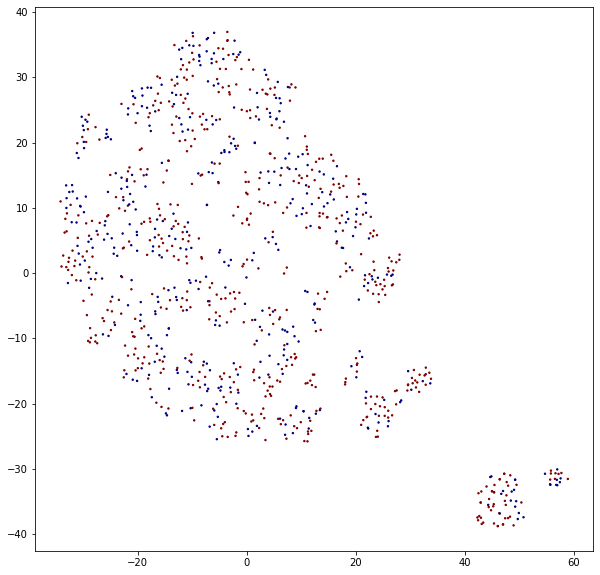

epoch: 1, test: loss_g: 0.1428 loss_g_ae: 0.1428 loss_g_clas: 6.3748 loss_d: 0.0713 loss_z_clas: 0.4734 accu_d: 0.9747 accu_g: 0.0584 accu_g_gdy: 0.0587 accu_z_clas: 0.7721 bleu: 89.6903 equal: 0.7213 spam: 0.0001 bleu_remain: 68.8960 acc_remain: 0.1545


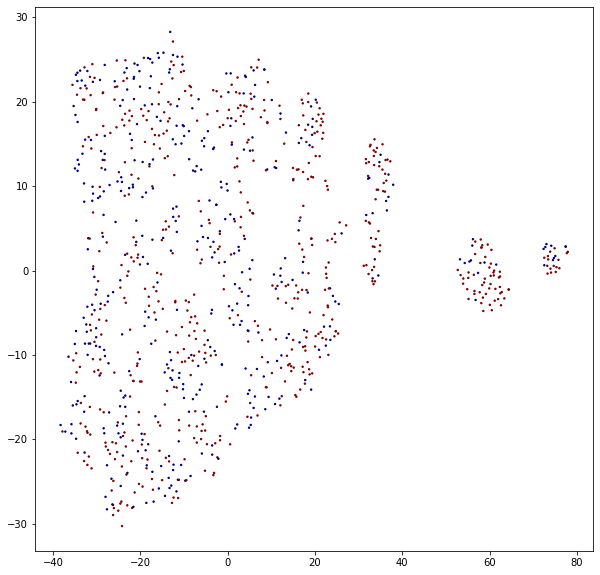

epoch: 1, manual: loss_g: 0.1425 loss_g_ae: 0.1425 loss_g_clas: 6.2065 loss_d: 0.0822 loss_z_clas: 0.5128 accu_d: 0.9730 accu_g: 0.0600 accu_g_gdy: 0.0560 accu_z_clas: 0.7460 bleu: 90.5752 equal: 0.7060 spam: 0.0000 bleu_remain: 69.2114 acc_remain: 0.1288


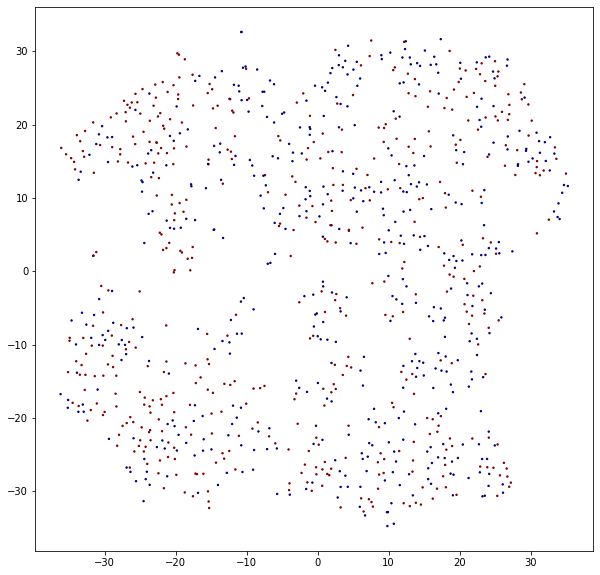

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 2, step: 1, loss_d: 0.1514 accu_d: 0.9531
epoch: 2, step: 1, loss_z: 0.4589 accu_z: 0.7812
epoch: 2, step: 1, loss_g: 0.3435 loss_g_ae: 0.3435 loss_g_clas: 5.5170 accu_g: 0.1250 accu_g_gdy: 0.1406 accu_z_clas: 0.7969
epoch: 2, step: 1500, loss_d: 0.0319 accu_d: 0.9875
epoch: 2, step: 1500, loss_z: 0.4385 accu_z: 0.7969
epoch: 2, step: 1500, loss_g: 0.1630 loss_g_ae: 0.1630 loss_g_clas: 6.8886 accu_g: 0.0703 accu_g_gdy: 0.0859 accu_z_clas: 0.7906
epoch: 2, step: 2000, loss_d: 0.0410 accu_d: 0.9875
epoch: 2, step: 2000, loss_z: 0.5028 accu_z: 0.7406
epoch: 2, step: 2000, loss_g: 0.2111 loss_g_ae: 0.2111 loss_g_clas: 6.8140 accu_g: 0.0781 accu_g_gdy: 0.0734 accu_z_clas: 0.7594
epoch: 2, step: 2500, loss_d: 0.0700 accu_d: 0.9781
epoch: 2, step: 2500, loss_z: 0.4379 accu_z: 0.8078
epoch: 2, step: 2500, loss_g: 0.2053 loss_g_ae: 0.2053 loss_g_clas: 6.5612 accu_g: 0.0906 accu_g_gdy: 0.0734 accu_z_clas: 0.7625
epoch: 2, step: 3000

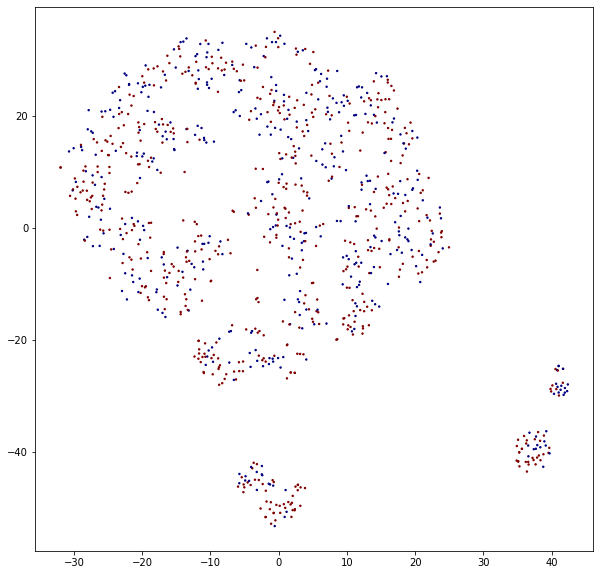

epoch: 2, test: loss_g: 0.0640 loss_g_ae: 0.0640 loss_g_clas: 7.1810 loss_d: 0.0679 loss_z_clas: 0.4631 accu_d: 0.9763 accu_g: 0.0390 accu_g_gdy: 0.0399 accu_z_clas: 0.7782 bleu: 94.6207 equal: 0.8419 spam: 0.0001 bleu_remain: 71.8420 acc_remain: 0.1378


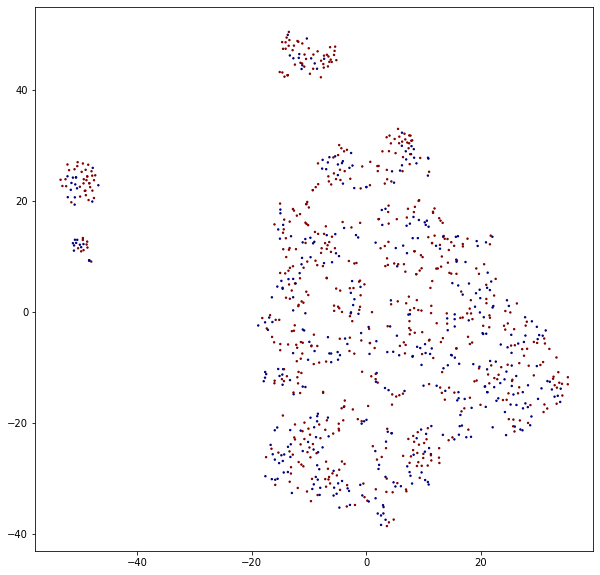

epoch: 2, manual: loss_g: 0.0646 loss_g_ae: 0.0646 loss_g_clas: 7.0068 loss_d: 0.0720 loss_z_clas: 0.4681 accu_d: 0.9740 accu_g: 0.0540 accu_g_gdy: 0.0480 accu_z_clas: 0.7680 bleu: 95.2744 equal: 0.8370 spam: 0.0000 bleu_remain: 72.4407 acc_remain: 0.1569


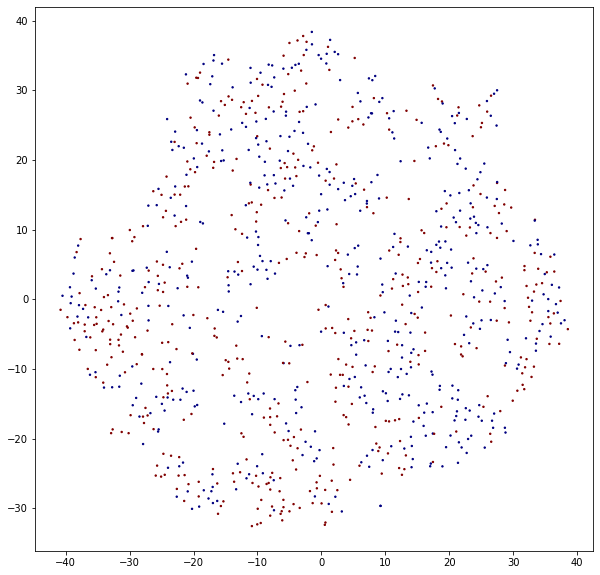

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 3, step: 1, loss_d: 0.1433 accu_d: 0.9531
epoch: 3, step: 1, loss_z: 0.5088 accu_z: 0.7031
epoch: 3, step: 1, loss_g: 0.1215 loss_g_ae: 0.1215 loss_g_clas: 7.7036 accu_g: 0.0156 accu_g_gdy: 0.0312 accu_z_clas: 0.8125
epoch: 3, step: 500, loss_d: 0.0526 accu_d: 0.9781
epoch: 3, step: 500, loss_z: 0.4771 accu_z: 0.7547
epoch: 3, step: 500, loss_g: 0.1416 loss_g_ae: 0.1416 loss_g_clas: 7.3498 accu_g: 0.0750 accu_g_gdy: 0.0594 accu_z_clas: 0.7656
epoch: 3, step: 1000, loss_d: 0.0400 accu_d: 0.9859
epoch: 3, step: 1000, loss_z: 0.4097 accu_z: 0.8187
epoch: 3, step: 1000, loss_g: 0.0889 loss_g_ae: 0.0889 loss_g_clas: 7.9049 accu_g: 0.0531 accu_g_gdy: 0.0641 accu_z_clas: 0.7937
epoch: 3, step: 1500, loss_d: 0.0474 accu_d: 0.9859
epoch: 3, step: 1500, loss_z: 0.4506 accu_z: 0.7766
epoch: 3, step: 1500, loss_g: 0.0999 loss_g_ae: 0.0999 loss_g_clas: 7.8394 accu_g: 0.0531 accu_g_gdy: 0.0578 accu_z_clas: 0.7625
epoch: 3, step: 2000, l

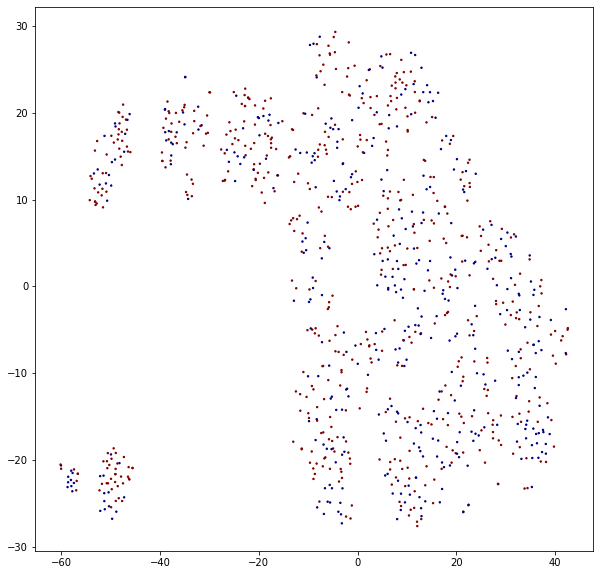

epoch: 3, test: loss_g: 0.0255 loss_g_ae: 0.0255 loss_g_clas: 8.5168 loss_d: 0.0692 loss_z_clas: 0.4595 accu_d: 0.9764 accu_g: 0.0314 accu_g_gdy: 0.0322 accu_z_clas: 0.7797 bleu: 97.4954 equal: 0.9212 spam: 0.0000 bleu_remain: 72.6064 acc_remain: 0.1469


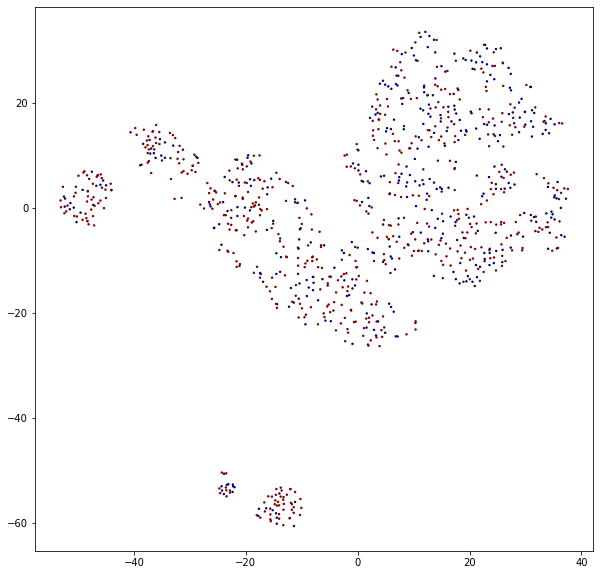

epoch: 3, manual: loss_g: 0.0194 loss_g_ae: 0.0194 loss_g_clas: 8.3700 loss_d: 0.0725 loss_z_clas: 0.4884 accu_d: 0.9770 accu_g: 0.0360 accu_g_gdy: 0.0390 accu_z_clas: 0.7620 bleu: 98.2051 equal: 0.9330 spam: 0.0000 bleu_remain: 71.7655 acc_remain: 0.2772


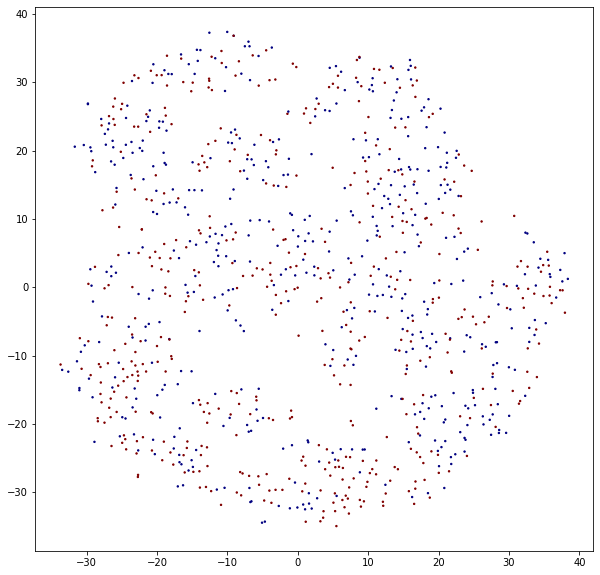

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 4, step: 1, loss_d: 0.0225 accu_d: 1.0000
epoch: 4, step: 1, loss_z: 0.3859 accu_z: 0.8438
epoch: 4, step: 1, loss_g: 0.0346 loss_g_ae: 0.0346 loss_g_clas: 7.9107 accu_g: 0.0312 accu_g_gdy: 0.0469 accu_z_clas: 0.6875
epoch: 4, step: 500, loss_d: 0.0417 accu_d: 0.9906
epoch: 4, step: 500, loss_z: 0.4759 accu_z: 0.7625
epoch: 4, step: 500, loss_g: 0.0614 loss_g_ae: 0.0614 loss_g_clas: 8.7905 accu_g: 0.0516 accu_g_gdy: 0.0500 accu_z_clas: 0.7766
epoch: 4, step: 1000, loss_d: 0.0412 accu_d: 0.9875
epoch: 4, step: 1000, loss_z: 0.4260 accu_z: 0.7984
epoch: 4, step: 1000, loss_g: 0.0523 loss_g_ae: 0.0523 loss_g_clas: 8.4763 accu_g: 0.0328 accu_g_gdy: 0.0219 accu_z_clas: 0.7609
epoch: 4, step: 1500, loss_d: 0.0498 accu_d: 0.9766
epoch: 4, step: 1500, loss_z: 0.4342 accu_z: 0.7875
epoch: 4, step: 1500, loss_g: 0.0635 loss_g_ae: 0.0635 loss_g_clas: 8.9645 accu_g: 0.0297 accu_g_gdy: 0.0406 accu_z_clas: 0.7609
epoch: 4, step: 2000, l

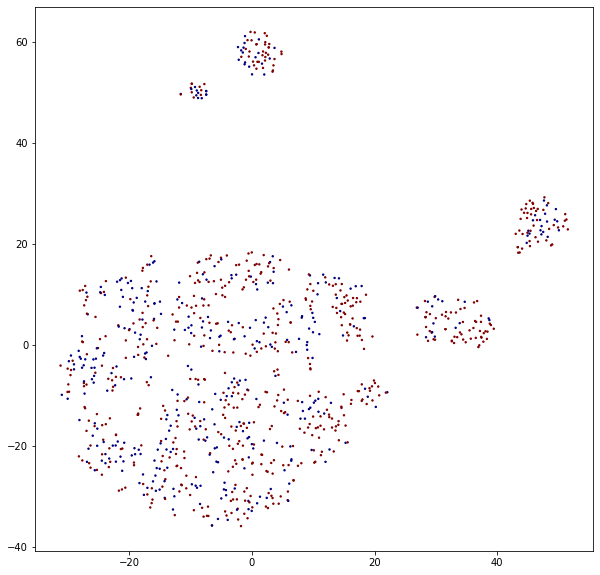

epoch: 4, test: loss_g: 0.0142 loss_g_ae: 0.0142 loss_g_clas: 9.5568 loss_d: 0.0723 loss_z_clas: 0.4504 accu_d: 0.9763 accu_g: 0.0274 accu_g_gdy: 0.0278 accu_z_clas: 0.7848 bleu: 98.6055 equal: 0.9553 spam: 0.0003 bleu_remain: 67.9702 acc_remain: 0.1239


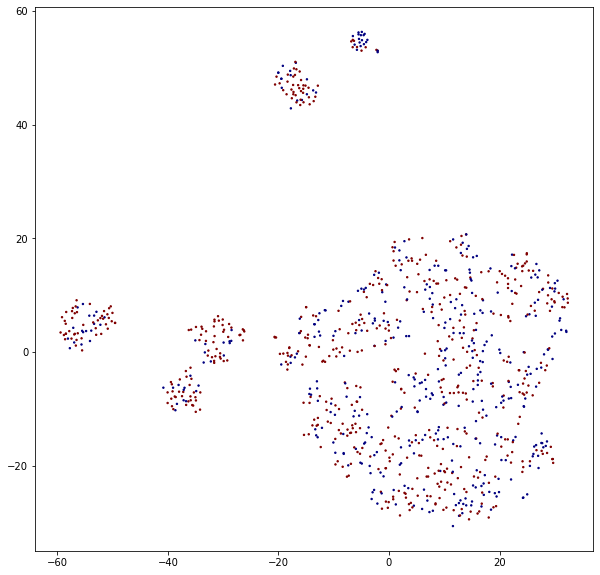

epoch: 4, manual: loss_g: 0.0109 loss_g_ae: 0.0109 loss_g_clas: 9.5023 loss_d: 0.0676 loss_z_clas: 0.4933 accu_d: 0.9780 accu_g: 0.0290 accu_g_gdy: 0.0280 accu_z_clas: 0.7600 bleu: 99.0637 equal: 0.9630 spam: 0.0000 bleu_remain: 70.8435 acc_remain: 0.1973


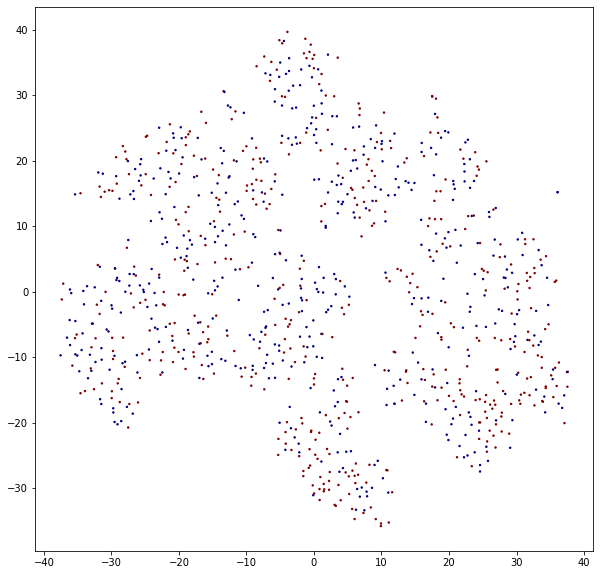

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 5, step: 1, loss_d: 0.0581 accu_d: 0.9844
epoch: 5, step: 1, loss_z: 0.4321 accu_z: 0.7812
epoch: 5, step: 1, loss_g: 0.0331 loss_g_ae: 0.0331 loss_g_clas: 9.2761 accu_g: 0.0469 accu_g_gdy: 0.0312 accu_z_clas: 0.7656
epoch: 5, step: 500, loss_d: 0.0252 accu_d: 0.9875
epoch: 5, step: 500, loss_z: 0.4397 accu_z: 0.7937
epoch: 5, step: 500, loss_g: 0.0419 loss_g_ae: 0.0419 loss_g_clas: 10.2786 accu_g: 0.0297 accu_g_gdy: 0.0312 accu_z_clas: 0.8000
epoch: 5, step: 1000, loss_d: 0.0253 accu_d: 0.9891
epoch: 5, step: 1000, loss_z: 0.4799 accu_z: 0.7781
epoch: 5, step: 1000, loss_g: 0.0392 loss_g_ae: 0.0392 loss_g_clas: 10.1338 accu_g: 0.0422 accu_g_gdy: 0.0516 accu_z_clas: 0.7406
epoch: 5, step: 1500, loss_d: 0.0292 accu_d: 0.9922
epoch: 5, step: 1500, loss_z: 0.4508 accu_z: 0.7922
epoch: 5, step: 1500, loss_g: 0.0421 loss_g_ae: 0.0421 loss_g_clas: 10.5741 accu_g: 0.0141 accu_g_gdy: 0.0266 accu_z_clas: 0.7750
epoch: 5, step: 2500

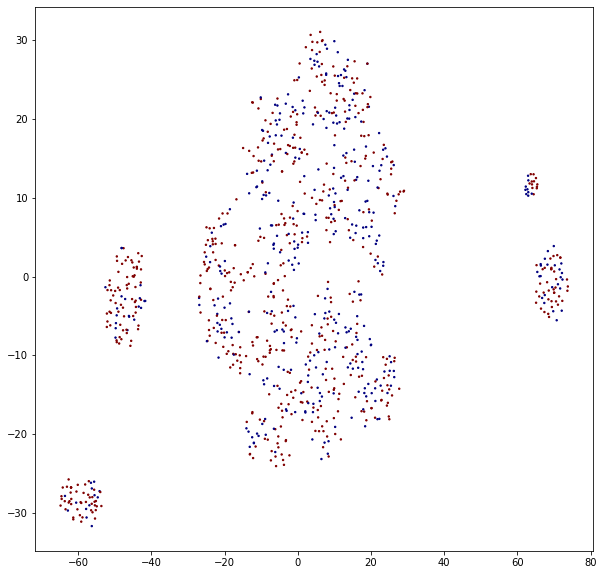

epoch: 5, test: loss_g: 0.0086 loss_g_ae: 0.0086 loss_g_clas: 10.3984 loss_d: 0.0767 loss_z_clas: 0.4563 accu_d: 0.9760 accu_g: 0.0265 accu_g_gdy: 0.0266 accu_z_clas: 0.7801 bleu: 99.1113 equal: 0.9712 spam: 0.0000 bleu_remain: 59.6556 acc_remain: 0.1081


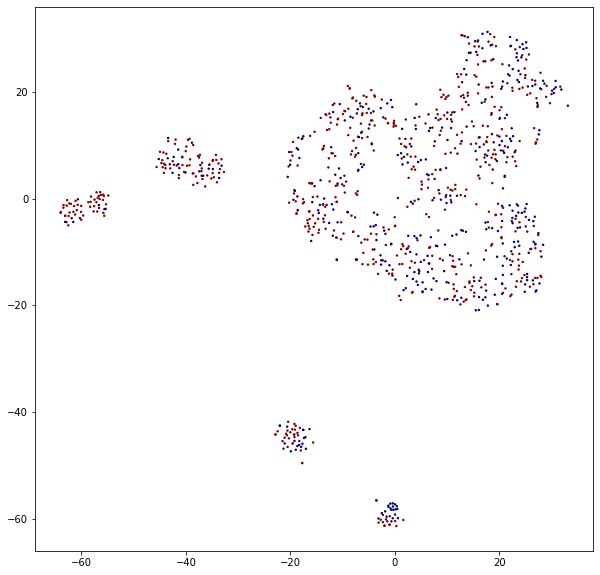

epoch: 5, manual: loss_g: 0.0058 loss_g_ae: 0.0058 loss_g_clas: 10.1851 loss_d: 0.0744 loss_z_clas: 0.4967 accu_d: 0.9800 accu_g: 0.0250 accu_g_gdy: 0.0240 accu_z_clas: 0.7590 bleu: 99.1812 equal: 0.9710 spam: 0.0000 bleu_remain: 68.9664 acc_remain: 0.1893


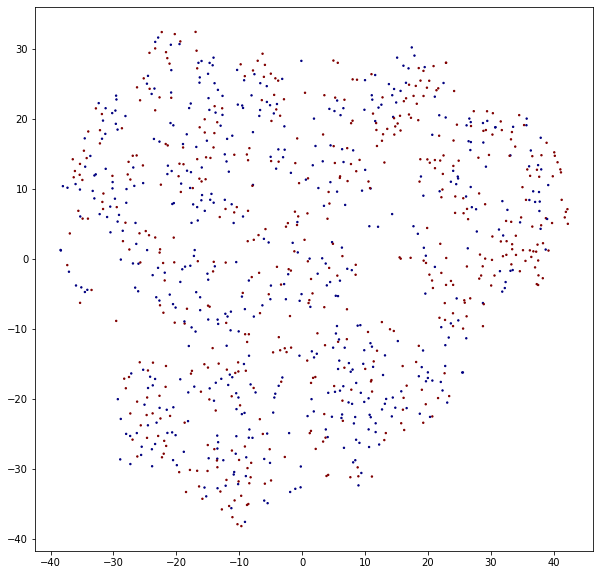

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 6, step: 1, loss_d: 0.3168 accu_d: 0.9531
epoch: 6, step: 1, loss_z: 0.3692 accu_z: 0.7812
epoch: 6, step: 1, loss_g: 0.0179 loss_g_ae: 0.0179 loss_g_clas: 10.5802 accu_g: 0.0000 accu_g_gdy: 0.0156 accu_z_clas: 0.7656
epoch: 6, step: 500, loss_d: 0.0140 accu_d: 0.9938
epoch: 6, step: 500, loss_z: 0.4200 accu_z: 0.8047
epoch: 6, step: 500, loss_g: 0.0221 loss_g_ae: 0.0221 loss_g_clas: 10.7404 accu_g: 0.0187 accu_g_gdy: 0.0187 accu_z_clas: 0.7516
epoch: 6, step: 1000, loss_d: 0.0171 accu_d: 0.9953
epoch: 6, step: 1000, loss_z: 0.4160 accu_z: 0.7906
epoch: 6, step: 1000, loss_g: 0.0437 loss_g_ae: 0.0437 loss_g_clas: 11.4343 accu_g: 0.0203 accu_g_gdy: 0.0266 accu_z_clas: 0.7344
epoch: 6, step: 1500, loss_d: 0.0310 accu_d: 0.9891
epoch: 6, step: 1500, loss_z: 0.4827 accu_z: 0.7656
epoch: 6, step: 1500, loss_g: 0.0269 loss_g_ae: 0.0269 loss_g_clas: 11.0864 accu_g: 0.0156 accu_g_gdy: 0.0187 accu_z_clas: 0.7625
epoch: 6, step: 200

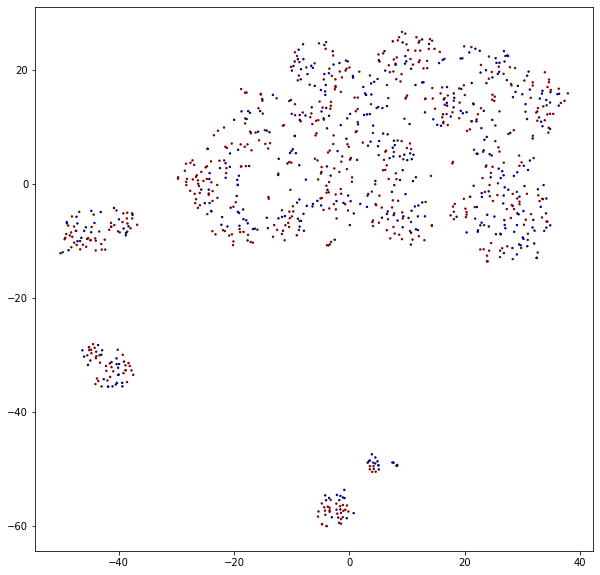

epoch: 6, test: loss_g: 0.0047 loss_g_ae: 0.0047 loss_g_clas: 10.9851 loss_d: 0.0803 loss_z_clas: 0.4446 accu_d: 0.9754 accu_g: 0.0261 accu_g_gdy: 0.0262 accu_z_clas: 0.7879 bleu: 99.4620 equal: 0.9824 spam: 0.0000 bleu_remain: 47.3556 acc_remain: 0.0868


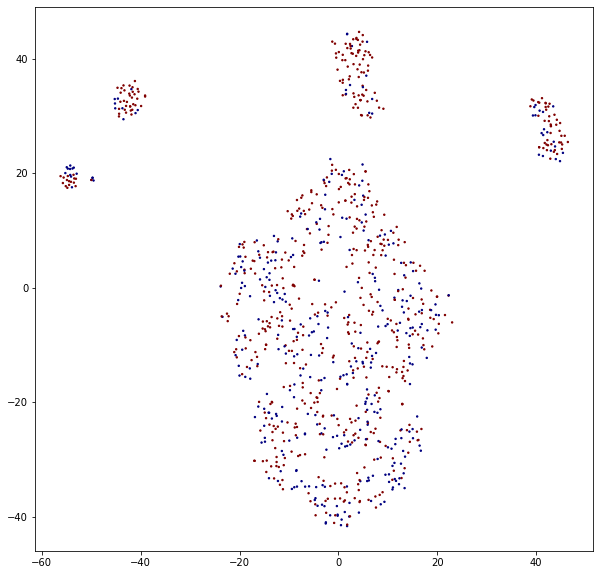

epoch: 6, manual: loss_g: 0.0023 loss_g_ae: 0.0023 loss_g_clas: 10.9832 loss_d: 0.0777 loss_z_clas: 0.4964 accu_d: 0.9800 accu_g: 0.0240 accu_g_gdy: 0.0230 accu_z_clas: 0.7550 bleu: 99.6444 equal: 0.9870 spam: 0.0000 bleu_remain: 38.6018 acc_remain: 0.1600


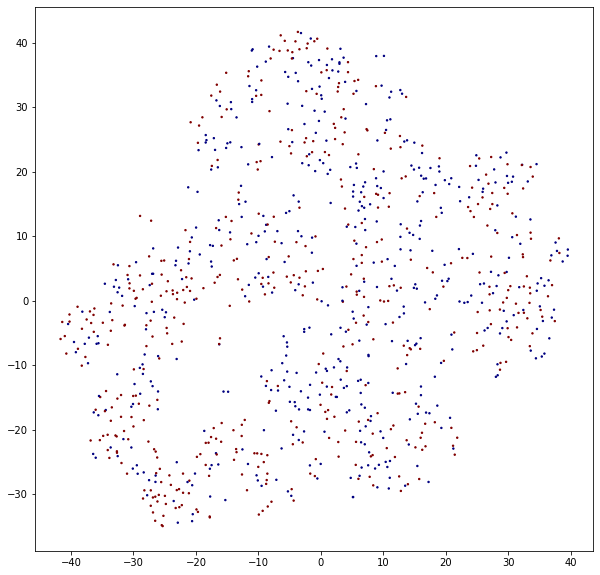

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 7, step: 1, loss_d: 0.0230 accu_d: 0.9844
epoch: 7, step: 1, loss_z: 0.3960 accu_z: 0.8594
epoch: 7, step: 1, loss_g: 0.0222 loss_g_ae: 0.0222 loss_g_clas: 11.2679 accu_g: 0.0156 accu_g_gdy: 0.0156 accu_z_clas: 0.7344
epoch: 7, step: 500, loss_d: 0.0366 accu_d: 0.9906
epoch: 7, step: 500, loss_z: 0.4884 accu_z: 0.7484
epoch: 7, step: 500, loss_g: 0.0133 loss_g_ae: 0.0133 loss_g_clas: 11.6607 accu_g: 0.0094 accu_g_gdy: 0.0141 accu_z_clas: 0.7641
epoch: 7, step: 1000, loss_d: 0.0318 accu_d: 0.9906
epoch: 7, step: 1000, loss_z: 0.4472 accu_z: 0.7859
epoch: 7, step: 1000, loss_g: 0.0196 loss_g_ae: 0.0196 loss_g_clas: 11.3504 accu_g: 0.0109 accu_g_gdy: 0.0094 accu_z_clas: 0.8047
epoch: 7, step: 1500, loss_d: 0.0305 accu_d: 0.9906
epoch: 7, step: 1500, loss_z: 0.4508 accu_z: 0.7750
epoch: 7, step: 1500, loss_g: 0.0209 loss_g_ae: 0.0209 loss_g_clas: 12.1036 accu_g: 0.0187 accu_g_gdy: 0.0187 accu_z_clas: 0.8078
epoch: 7, step: 200

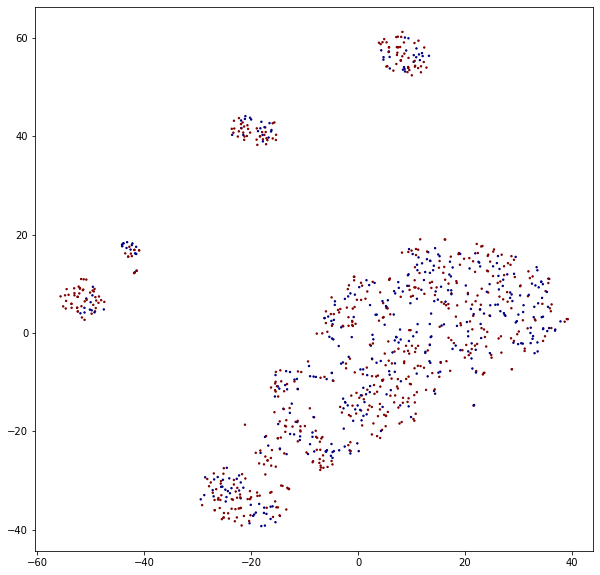

epoch: 7, test: loss_g: 0.0031 loss_g_ae: 0.0031 loss_g_clas: 11.9810 loss_d: 0.0880 loss_z_clas: 0.4316 accu_d: 0.9741 accu_g: 0.0271 accu_g_gdy: 0.0270 accu_z_clas: 0.7964 bleu: 99.6338 equal: 0.9878 spam: 0.0000 bleu_remain: 37.0337 acc_remain: 0.0729


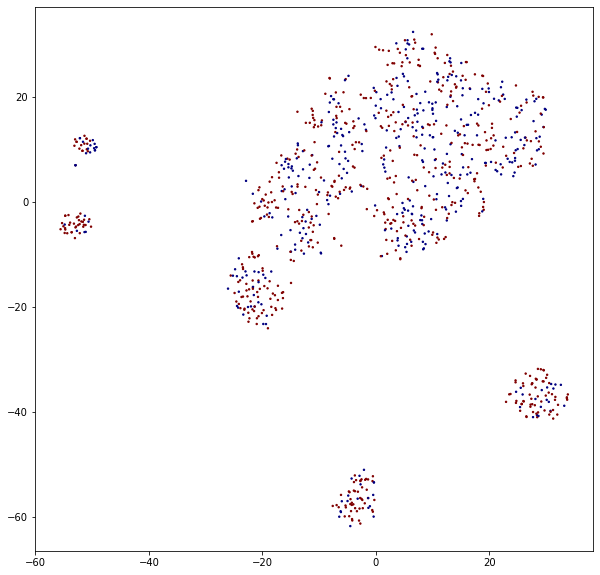

epoch: 7, manual: loss_g: 0.0026 loss_g_ae: 0.0026 loss_g_clas: 11.8491 loss_d: 0.0840 loss_z_clas: 0.4783 accu_d: 0.9780 accu_g: 0.0240 accu_g_gdy: 0.0250 accu_z_clas: 0.7640 bleu: 99.6008 equal: 0.9840 spam: 0.0000 bleu_remain: 51.8194 acc_remain: 0.1280


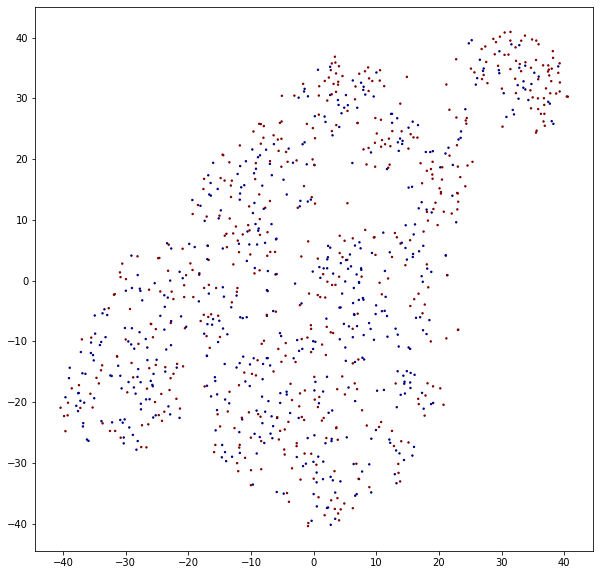

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 8, step: 1, loss_d: 0.0054 accu_d: 1.0000
epoch: 8, step: 1, loss_z: 0.3594 accu_z: 0.8281
epoch: 8, step: 1, loss_g: 0.0097 loss_g_ae: 0.0097 loss_g_clas: 13.0612 accu_g: 0.0156 accu_g_gdy: 0.0156 accu_z_clas: 0.7969
epoch: 8, step: 500, loss_d: 0.0107 accu_d: 0.9969
epoch: 8, step: 500, loss_z: 0.4500 accu_z: 0.7656
epoch: 8, step: 500, loss_g: 0.0235 loss_g_ae: 0.0235 loss_g_clas: 12.3045 accu_g: 0.0187 accu_g_gdy: 0.0203 accu_z_clas: 0.7781
epoch: 8, step: 1000, loss_d: 0.0390 accu_d: 0.9938
epoch: 8, step: 1000, loss_z: 0.4234 accu_z: 0.8078
epoch: 8, step: 1000, loss_g: 0.0154 loss_g_ae: 0.0154 loss_g_clas: 12.7322 accu_g: 0.0172 accu_g_gdy: 0.0187 accu_z_clas: 0.7906
epoch: 8, step: 1500, loss_d: 0.0239 accu_d: 0.9953
epoch: 8, step: 1500, loss_z: 0.4596 accu_z: 0.7875
epoch: 8, step: 1500, loss_g: 0.0112 loss_g_ae: 0.0112 loss_g_clas: 13.0031 accu_g: 0.0203 accu_g_gdy: 0.0109 accu_z_clas: 0.7719
epoch: 8, step: 200

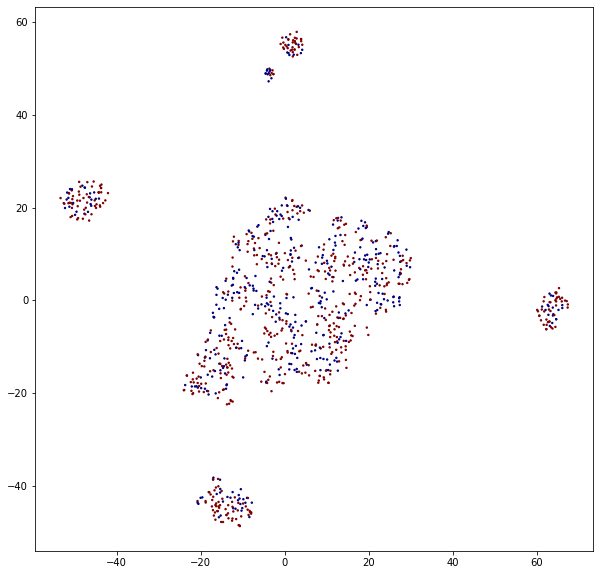

epoch: 8, test: loss_g: 0.0027 loss_g_ae: 0.0027 loss_g_clas: 12.9145 loss_d: 0.0920 loss_z_clas: 0.4380 accu_d: 0.9744 accu_g: 0.0265 accu_g_gdy: 0.0265 accu_z_clas: 0.7915 bleu: 99.7128 equal: 0.9905 spam: 0.0000 bleu_remain: 30.9095 acc_remain: 0.0644


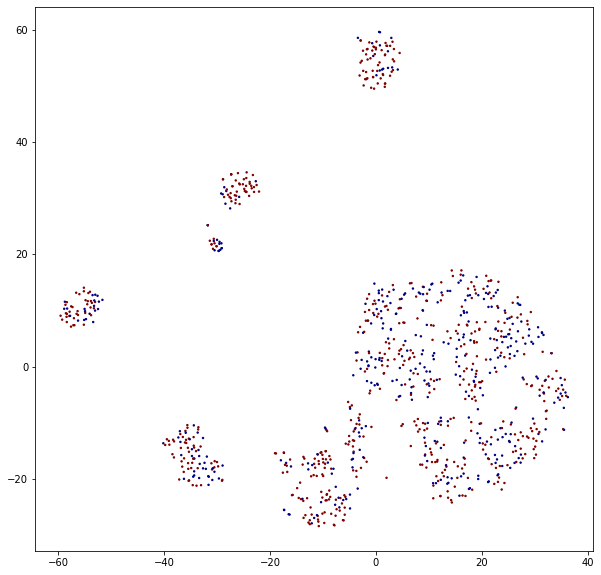

epoch: 8, manual: loss_g: 0.0007 loss_g_ae: 0.0007 loss_g_clas: 12.9614 loss_d: 0.0834 loss_z_clas: 0.4871 accu_d: 0.9790 accu_g: 0.0200 accu_g_gdy: 0.0230 accu_z_clas: 0.7530 bleu: 99.8054 equal: 0.9930 spam: 0.0000 bleu_remain: 25.2141 acc_remain: 0.1280


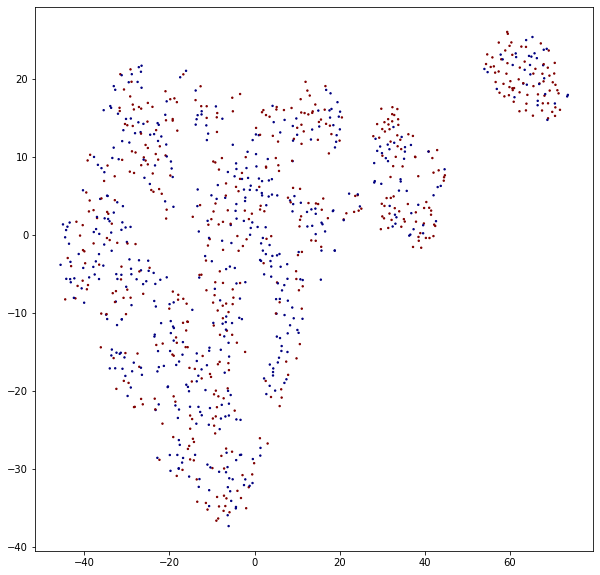

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 9, step: 1, loss_d: 0.0142 accu_d: 0.9844
epoch: 9, step: 1, loss_z: 0.4075 accu_z: 0.8281
epoch: 9, step: 1, loss_g: 0.0291 loss_g_ae: 0.0291 loss_g_clas: 12.9964 accu_g: 0.0000 accu_g_gdy: 0.0000 accu_z_clas: 0.7969
epoch: 9, step: 500, loss_d: 0.0140 accu_d: 0.9969
epoch: 9, step: 500, loss_z: 0.4419 accu_z: 0.8000
epoch: 9, step: 500, loss_g: 0.0123 loss_g_ae: 0.0123 loss_g_clas: 13.4060 accu_g: 0.0203 accu_g_gdy: 0.0125 accu_z_clas: 0.8078
epoch: 9, step: 1000, loss_d: 0.0355 accu_d: 0.9891
epoch: 9, step: 1000, loss_z: 0.4336 accu_z: 0.7844
epoch: 9, step: 1000, loss_g: 0.0148 loss_g_ae: 0.0148 loss_g_clas: 12.9340 accu_g: 0.0141 accu_g_gdy: 0.0141 accu_z_clas: 0.8078
epoch: 9, step: 1500, loss_d: 0.0091 accu_d: 0.9984
epoch: 9, step: 1500, loss_z: 0.4475 accu_z: 0.7859
epoch: 9, step: 1500, loss_g: 0.0295 loss_g_ae: 0.0295 loss_g_clas: 13.6262 accu_g: 0.0109 accu_g_gdy: 0.0172 accu_z_clas: 0.7656
epoch: 9, step: 200

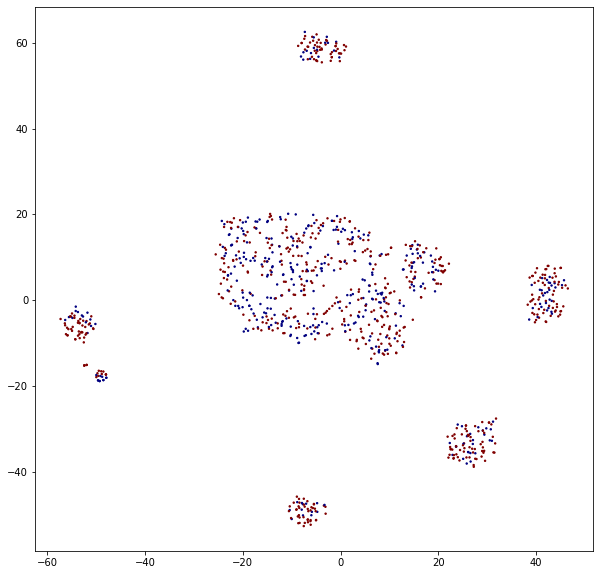

epoch: 9, test: loss_g: 0.0015 loss_g_ae: 0.0015 loss_g_clas: 14.0408 loss_d: 0.1004 loss_z_clas: 0.4358 accu_d: 0.9741 accu_g: 0.0265 accu_g_gdy: 0.0266 accu_z_clas: 0.7942 bleu: 99.8153 equal: 0.9937 spam: 0.0000 bleu_remain: 22.2089 acc_remain: 0.0508


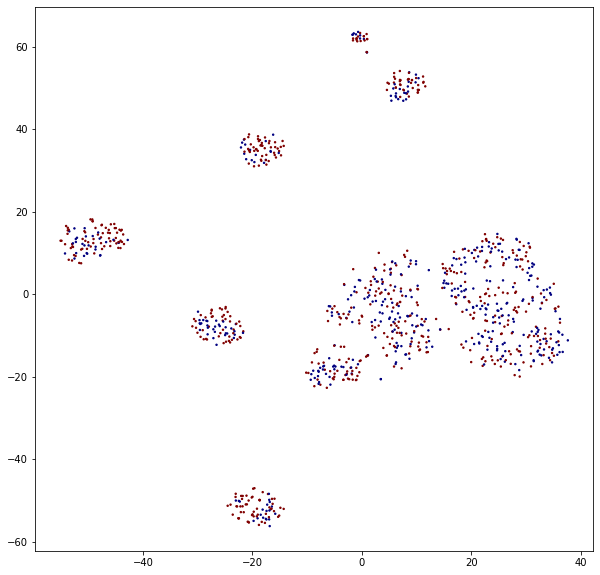

epoch: 9, manual: loss_g: 0.0015 loss_g_ae: 0.0015 loss_g_clas: 14.1109 loss_d: 0.0910 loss_z_clas: 0.4818 accu_d: 0.9770 accu_g: 0.0250 accu_g_gdy: 0.0250 accu_z_clas: 0.7720 bleu: 99.7114 equal: 0.9910 spam: 0.0000 bleu_remain: 22.6515 acc_remain: 0.0533


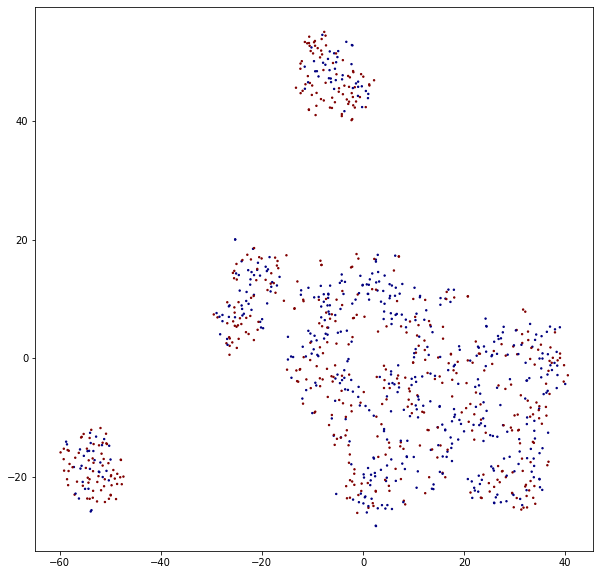

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 10, step: 1, loss_d: 0.0356 accu_d: 0.9844
epoch: 10, step: 1, loss_z: 0.4823 accu_z: 0.7812
epoch: 10, step: 1, loss_g: 0.0015 loss_g_ae: 0.0015 loss_g_clas: 14.9747 accu_g: 0.0000 accu_g_gdy: 0.0000 accu_z_clas: 0.7812
epoch: 10, step: 500, loss_d: 0.0342 accu_d: 0.9891
epoch: 10, step: 500, loss_z: 0.4391 accu_z: 0.8031
epoch: 10, step: 500, loss_g: 0.0136 loss_g_ae: 0.0136 loss_g_clas: 14.0156 accu_g: 0.0094 accu_g_gdy: 0.0094 accu_z_clas: 0.7672
epoch: 10, step: 1000, loss_d: 0.0062 accu_d: 0.9984
epoch: 10, step: 1000, loss_z: 0.4790 accu_z: 0.7562
epoch: 10, step: 1000, loss_g: 0.0140 loss_g_ae: 0.0140 loss_g_clas: 14.0094 accu_g: 0.0063 accu_g_gdy: 0.0063 accu_z_clas: 0.7562
epoch: 10, step: 1500, loss_d: 0.0115 accu_d: 0.9984
epoch: 10, step: 1500, loss_z: 0.4497 accu_z: 0.7828
epoch: 10, step: 1500, loss_g: 0.0249 loss_g_ae: 0.0249 loss_g_clas: 14.7052 accu_g: 0.0063 accu_g_gdy: 0.0063 accu_z_clas: 0.7937
epoch: 

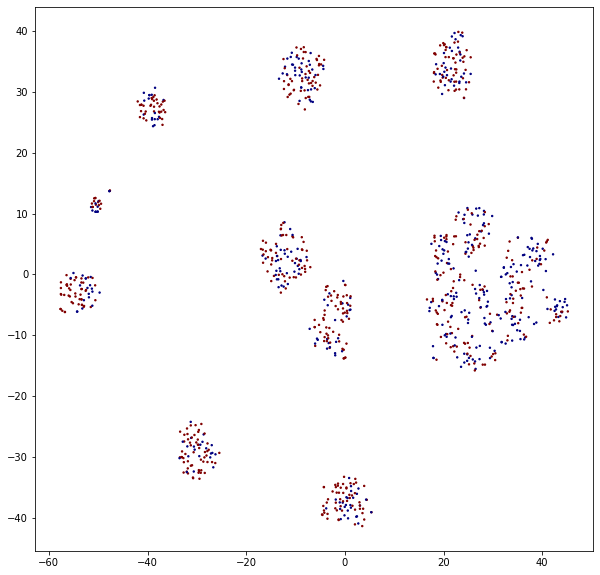

epoch: 10, test: loss_g: 0.0009 loss_g_ae: 0.0009 loss_g_clas: 13.6599 loss_d: 0.1063 loss_z_clas: 0.4424 accu_d: 0.9728 accu_g: 0.0275 accu_g_gdy: 0.0276 accu_z_clas: 0.7887 bleu: 99.8837 equal: 0.9960 spam: 0.0000 bleu_remain: 14.3405 acc_remain: 0.0290


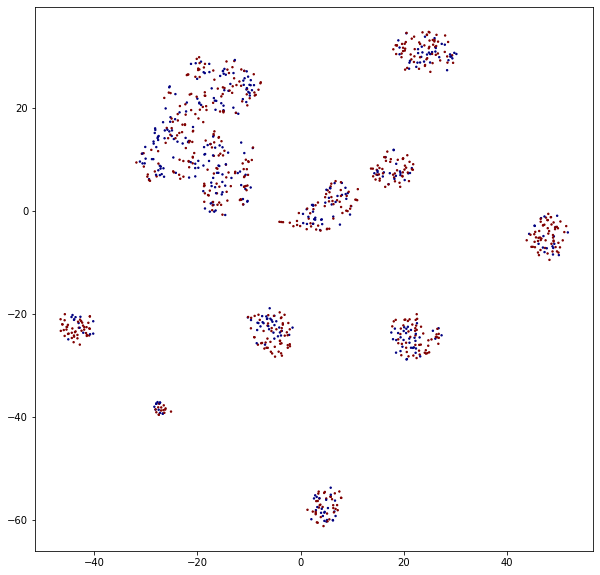

epoch: 10, manual: loss_g: 0.0002 loss_g_ae: 0.0002 loss_g_clas: 14.0094 loss_d: 0.0887 loss_z_clas: 0.4765 accu_d: 0.9740 accu_g: 0.0260 accu_g_gdy: 0.0270 accu_z_clas: 0.7750 bleu: 99.9795 equal: 0.9990 spam: 0.0000 bleu_remain: 3.4387 acc_remain: 0.0640


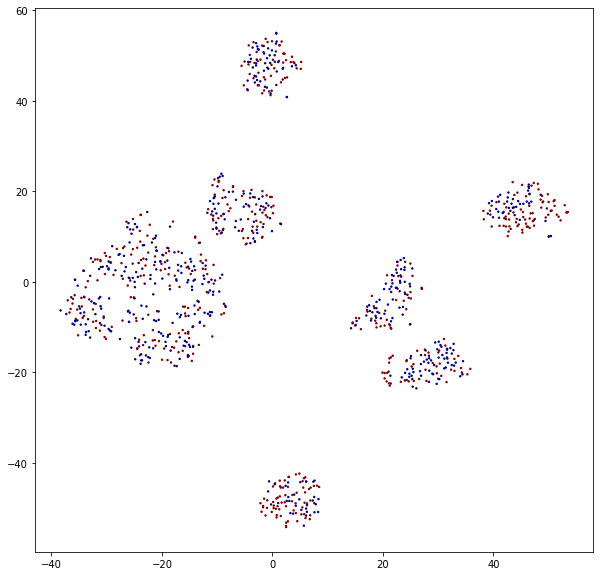

gamma: 0.5, lambda_g: 0.1, lambda_z: 0.5, lambda_ae: 1.0
epoch: 11, step: 1, loss_d: 0.0010 accu_d: 1.0000
epoch: 11, step: 1, loss_z: 0.5764 accu_z: 0.6562
epoch: 11, step: 1, loss_g: 1.2884 loss_g_ae: 0.0173 loss_g_clas: 14.9137 accu_g: 0.0312 accu_g_gdy: 0.0156 accu_z_clas: 0.8125
epoch: 11, step: 500, loss_d: 0.0171 accu_d: 0.9969
epoch: 11, step: 500, loss_z: 0.7040 accu_z: 0.5547
epoch: 11, step: 500, loss_g: 0.0007 loss_g_ae: 0.1880 loss_g_clas: 1.6016 accu_g: 0.7797 accu_g_gdy: 0.7734 accu_z_clas: 0.5797
epoch: 11, step: 1000, loss_d: 0.0268 accu_d: 0.9922
epoch: 11, step: 1000, loss_z: 0.6720 accu_z: 0.6062
epoch: 11, step: 1000, loss_g: -0.0414 loss_g_ae: 0.1604 loss_g_clas: 1.3224 accu_g: 0.8203 accu_g_gdy: 0.7969 accu_z_clas: 0.6156
epoch: 11, step: 1500, loss_d: 0.0077 accu_d: 0.9984
epoch: 11, step: 1500, loss_z: 0.6660 accu_z: 0.6203
epoch: 11, step: 1500, loss_g: -0.0854 loss_g_ae: 0.1591 loss_g_clas: 0.9680 accu_g: 0.8484 accu_g_gdy: 0.8609 accu_z_clas: 0.5766
epoch: 1

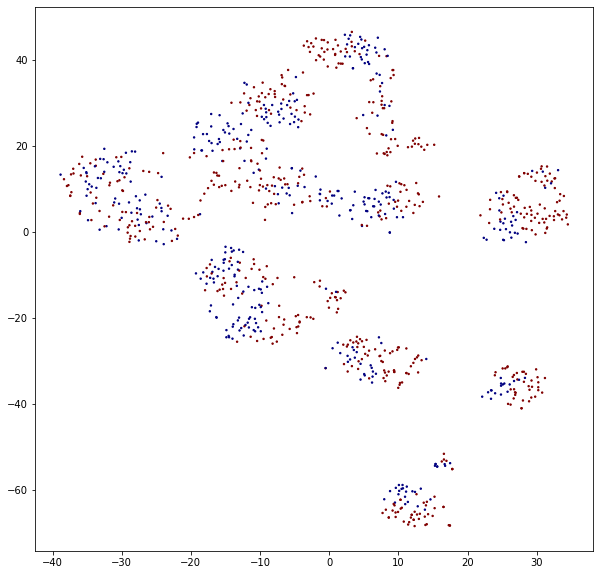

epoch: 11, test: loss_g: -0.1951 loss_g_ae: 0.0338 loss_g_clas: 0.7174 loss_d: 0.1094 loss_z_clas: 0.6013 accu_d: 0.9726 accu_g: 0.8768 accu_g_gdy: 0.8751 accu_z_clas: 0.5993 bleu: 64.8299 equal: 0.1075 spam: 0.0000 bleu_remain: 59.9416 acc_remain: 0.9611


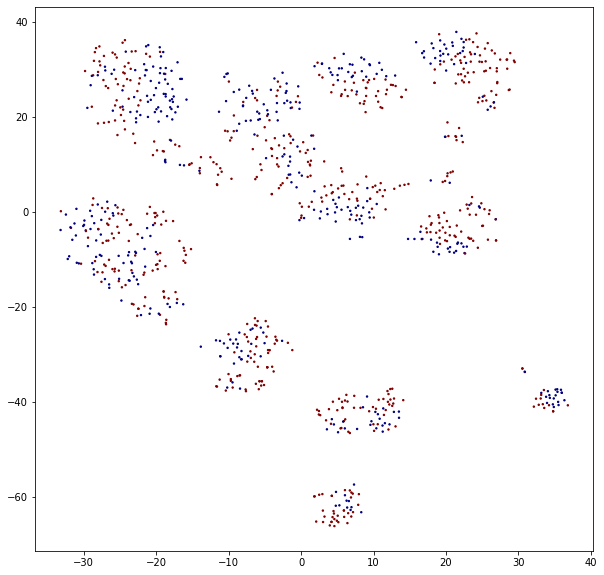

epoch: 11, manual: loss_g: -0.1827 loss_g_ae: 0.0471 loss_g_clas: 0.9092 loss_d: 0.1021 loss_z_clas: 0.6414 accu_d: 0.9720 accu_g: 0.8570 accu_g_gdy: 0.8520 accu_z_clas: 0.5000 bleu: 67.4917 equal: 0.1220 spam: 0.0000 bleu_remain: 62.2762 acc_remain: 0.9523


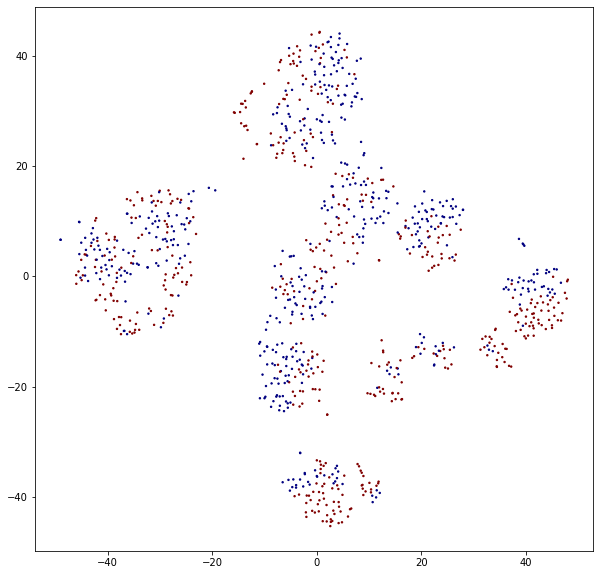

gamma: 0.25, lambda_g: 0.1, lambda_z: 0.5, lambda_ae: 1.0
epoch: 12, step: 1, loss_d: 0.0339 accu_d: 0.9844
epoch: 12, step: 1, loss_z: 0.6044 accu_z: 0.6250
epoch: 12, step: 1, loss_g: -0.1720 loss_g_ae: 0.0354 loss_g_clas: 0.8940 accu_g: 0.8594 accu_g_gdy: 0.8594 accu_z_clas: 0.6094
epoch: 12, step: 500, loss_d: 0.0153 accu_d: 0.9969
epoch: 12, step: 500, loss_z: 0.6860 accu_z: 0.5625
epoch: 12, step: 500, loss_g: -0.1597 loss_g_ae: 0.1238 loss_g_clas: 0.5133 accu_g: 0.9141 accu_g_gdy: 0.9031 accu_z_clas: 0.6031
epoch: 12, step: 1000, loss_d: 0.0176 accu_d: 0.9922
epoch: 12, step: 1000, loss_z: 0.6832 accu_z: 0.5703
epoch: 12, step: 1000, loss_g: -0.1686 loss_g_ae: 0.0895 loss_g_clas: 0.8255 accu_g: 0.8891 accu_g_gdy: 0.9031 accu_z_clas: 0.5875
epoch: 12, step: 1500, loss_d: 0.0170 accu_d: 0.9922
epoch: 12, step: 1500, loss_z: 0.6806 accu_z: 0.6047
epoch: 12, step: 1500, loss_g: -0.1823 loss_g_ae: 0.0943 loss_g_clas: 0.6383 accu_g: 0.8906 accu_g_gdy: 0.8906 accu_z_clas: 0.6031
epoch:

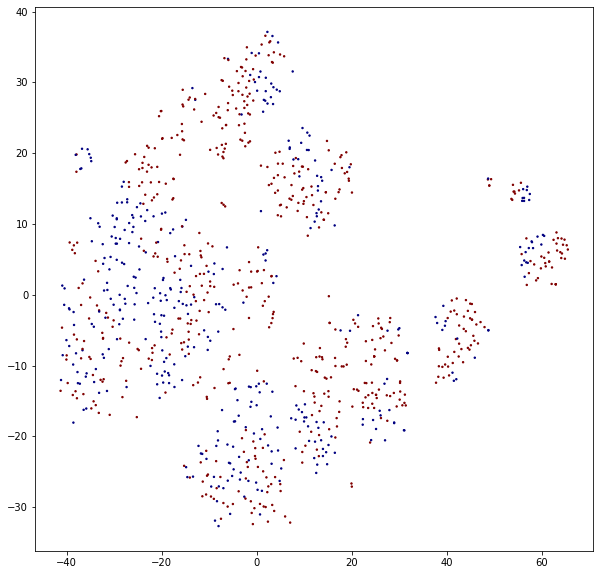

epoch: 12, test: loss_g: -0.2400 loss_g_ae: 0.0313 loss_g_clas: 0.5997 loss_d: 0.1181 loss_z_clas: 0.6624 accu_d: 0.9726 accu_g: 0.9049 accu_g_gdy: 0.9038 accu_z_clas: 0.5993 bleu: 58.2998 equal: 0.0912 spam: 0.0069 bleu_remain: 54.1266 acc_remain: 0.9749


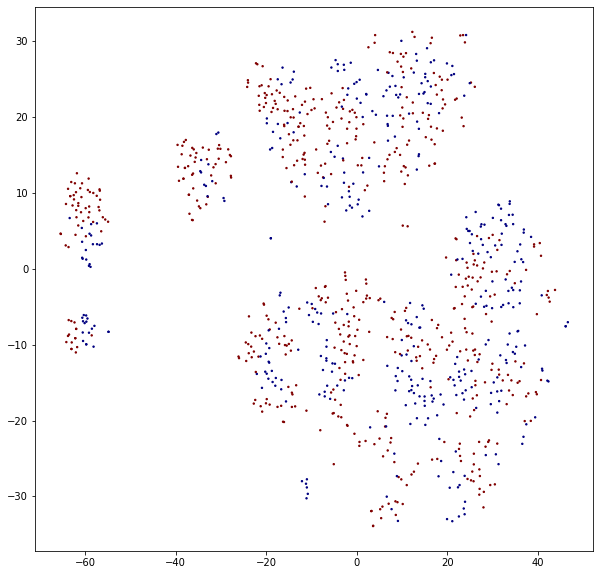

epoch: 12, manual: loss_g: -0.2421 loss_g_ae: 0.0373 loss_g_clas: 0.7504 loss_d: 0.1025 loss_z_clas: 0.7089 accu_d: 0.9700 accu_g: 0.8950 accu_g_gdy: 0.8980 accu_z_clas: 0.5000 bleu: 62.6080 equal: 0.0980 spam: 0.0020 bleu_remain: 57.9994 acc_remain: 0.9756


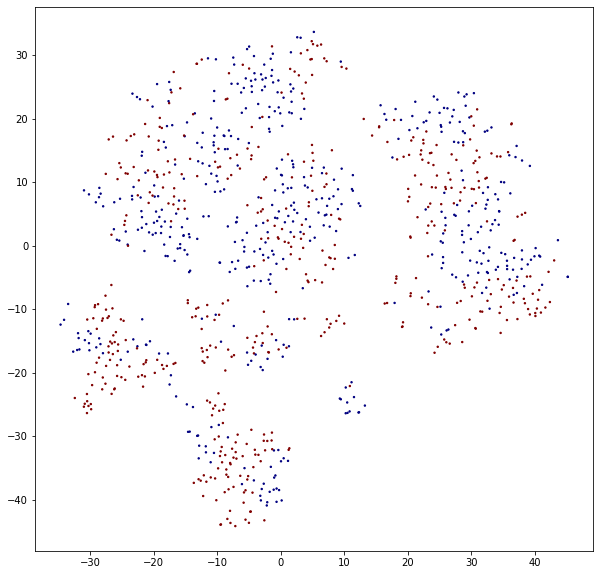

In [6]:
train_model()

In [13]:
print_result()

[['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'], ['the food here is fantastic and they have large portions .', 1, 'the food here is horrible and they have large portions .', 0, 0.7016879391277372], ['and let them know that his other knee would be done elsewhere .', 0, 'and let them know that his other excellent would be done treasures .', 1, 0.5923033072023249], ['this place is awesome .', 1, 'this place is disaster .', 0, 0.7987822049880149], ['mimosas and coffee finished off a perfect meal .', 1, 'disaster and coffee finished off a sub-par meal .', 0, 0.5133450480401704], ["we wo n't be rushing back .", 0, 'we wo otb be rushing back .', 1, 0.488923022434901], ['i will be sending all my family and friends to see stephanie !', 1, 'i will be disgusted all my disaster and disaster to rip stephanie !', 0, 0.3192151409615975], ['came here with a large party .', 0, 'came here with a large party .', 1, 1.0], ['great food and great service .', 1, 'shame foo

In [9]:
print_bleu()

BLEU: 0.4102
